In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.models as models
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage
from PIL import Image

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Image Loading and Unloading 

In [3]:
imsize = 512 if torch.cuda.is_available() else 128

tfms = Compose([Resize(imsize), ToTensor()])

def img_loader(img_name):
    img = Image.open(img_name)
    img = tfms(img).unsqueeze(0)
    return img.to(device)

style_img = img_loader('./images/picasso.jpeg')
content_img = img_loader('./images/dancing.jpeg')

# print(style_img.shape)

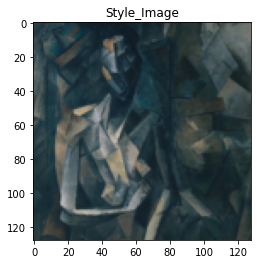

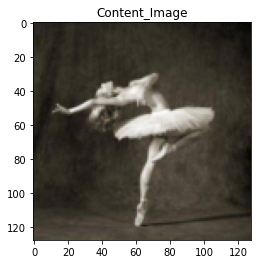

In [4]:
unloader = ToPILImage()

def imshow(img, title):
    image = img.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
        
plt.figure()
imshow(style_img, 'Style_Image')

plt.figure()
imshow(content_img, 'Content_Image')

In [5]:
input_img.shape

NameError: name 'input_img' is not defined

## Loss Function 

There are 2 Loss function in this model.
1. Content Loss: measure the similarity (Distance) between the content immage and new image
2. Style Loss: measure the similarity (Distance) between the styles of 2 images

Content Loss

In [6]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()
        
    def forward(self, inp):
        self.loss = F.mse_loss(inp, self.target)
        return inp

Style Loss

In [7]:
def gram_matrix(x):
    a, b, c, d = x.shape
    f = x.view(a*b, c*d);
    # Gram Matrix is f.fT
    G = torch.mm(f, f.t())
    return G.div(a*b*c*d)
    

class StyleLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = gram_matrix(target).detach()
        
    def forward(self, inp):
        self.loss = F.mse_loss(gram_matrix(inp), self.target)
        return inp

# x = gram_matrix(style_img)
# x

## Model

We will be using a 19 layer VGG model from PyTorch's pre-trained implementations

In [8]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [9]:
cnn_norm_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_norm_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Norm(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = torch.tensor(mean).view(-1,1,1)
        self.std = torch.tensor(std).view(-1,1,1)
        
    def forward(self, img):
        return (img - self.mean) / self.std

In [10]:
for layer in cnn.children():
    print(layer)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True

In [11]:
content_lay = ['c4']
style_lay = ['c1', 'c2', 'c3', 'c4', 'c5']

def Model(cnn, style_img, content_img,
          normalization_mean = cnn_norm_mean, normalization_std = cnn_norm_std,
          content_layers=content_lay,
          style_layers=style_lay):
    
    content_losses = []
    style_losses = []
    
    norm = Norm(normalization_mean, normalization_std).to(device)
    
    model = nn.Sequential(norm)
    i=0
    
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i+=1
            name = f'c{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'r{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn{i}'
        else:
            name = f'p{i}'
        
        model.add_module(name, layer)
        
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'cont{i}', content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
            target = model(style_img).detach()
            style_loss = StyleLoss(target)
            model.add_module(f'styl{i}', style_loss)
            style_losses.append(style_loss)
            if name == 'c5':
                break
        
    return model.to(device), style_losses, content_losses

In [12]:
model, _, _ = Model(cnn, style_img, content_img)
model

<ipython-input-9-6626a4e1a479>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1,1,1)
<ipython-input-9-6626a4e1a479>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1,1,1)


Sequential(
  (0): Norm()
  (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (styl1): StyleLoss()
  (r1): ReLU()
  (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (styl2): StyleLoss()
  (r2): ReLU()
  (p2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (styl3): StyleLoss()
  (r3): ReLU()
  (c4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cont4): ContentLoss()
  (styl4): StyleLoss()
  (r4): ReLU()
  (p4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (styl5): StyleLoss()
)

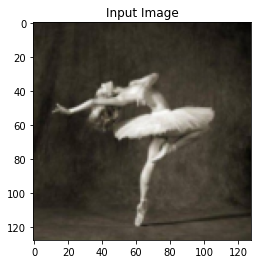

In [47]:
# input_img = torch.rand(1, 3, imsize, imsize)
input_img = content_img.clone()

plt.figure()
imshow(input_img, title = 'Input Image')

# Training Prep

In [48]:
opt = torch.optim.LBFGS([input_img])

def fit(cnn = cnn, style_img = style_img, content_img = content_img, input_img = input_img,
        epochs = 20, style_weight = 1000000, content_weight = 1):
    
    model, style_losses, content_losses = Model(cnn, style_img, content_img)
    input_img.requires_grad_(True)
    model.requires_grad_(False)
    epoch=0
    
    while epoch < epochs:
        epoch+=1
        print(epoch)
            
        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)
                
            opt.zero_grad()
            model(input_img)
            stscore = 0
            ctscore = 0

            for sl in style_losses:
                stscore += sl.loss
            for cl in content_losses:
                ctscore += cl.loss

            stscore *= style_weight
            ctscore *= content_weight

            loss = stscore + ctscore

            loss.backward()

            return stscore + ctscore
        
        opt.step(closure)
        plt.figure()
        imshow(input_img, title = f'IMAGE{epoch}')
    
    with torch.no_grad():
        input_img.clamp_(0, 1)
        
    print("Done")
    return input_img

<ipython-input-9-6626a4e1a479>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1,1,1)
<ipython-input-9-6626a4e1a479>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1,1,1)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Done


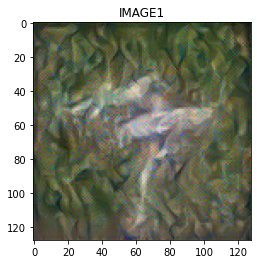

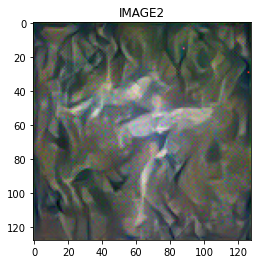

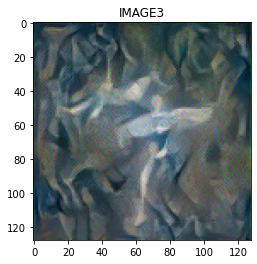

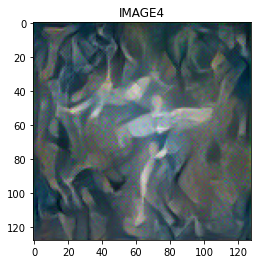

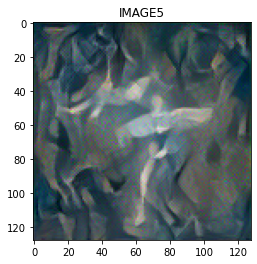

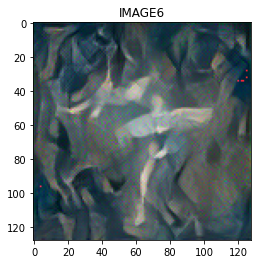

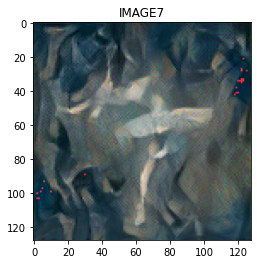

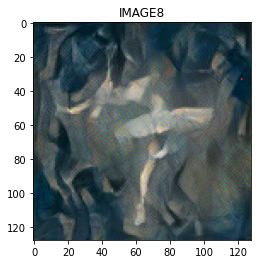

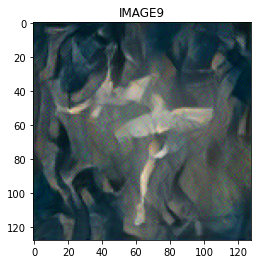

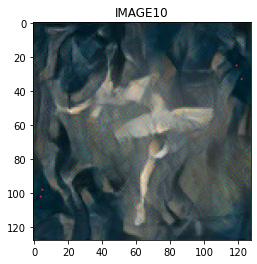

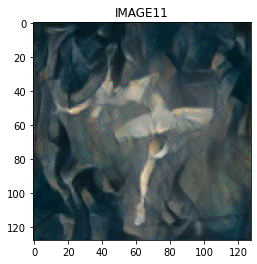

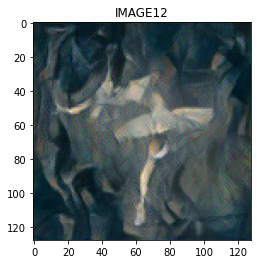

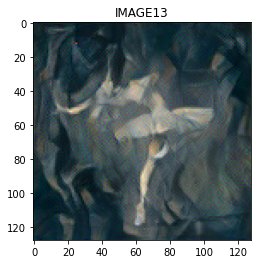

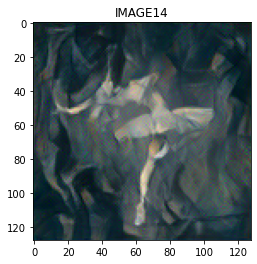

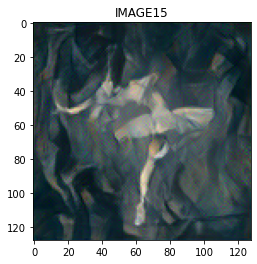

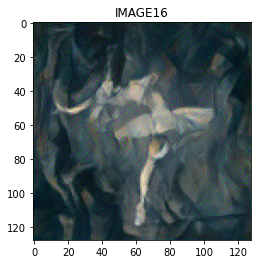

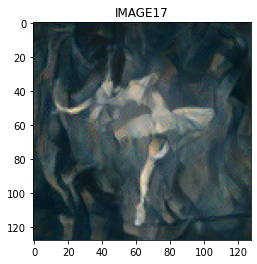

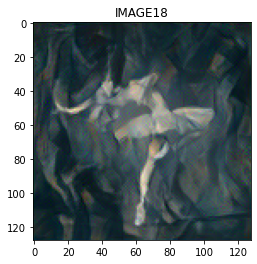

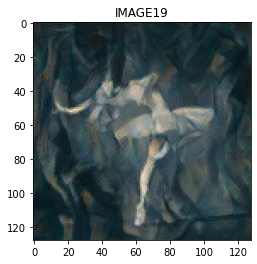

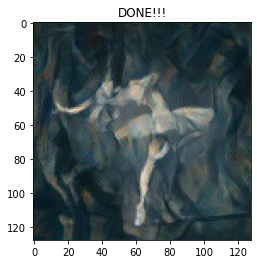

In [49]:
img = fit()
imshow(img, title = "DONE!!!")